In [40]:
# !pip install pydotplus

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import numpy as np
import pandas as pd
import yaml
import pydotplus
import ast

In [42]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py
%run ./src/model_build.py

In [43]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1
IS_NOTEBOOK = True

# Read yaml config and data

In [44]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
NUMERIC_FIELD_INFO = yaml_data['convert_obj_numeric']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']
IMPUTE_MISSING_VALUE_INFO = yaml_data['impute_missing_value']
OHE_FIELDS = ast.literal_eval(yaml_data['one_hot_encode'])

In [45]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [46]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

In [47]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

# Preprocessing

In [48]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [49]:
# Replace all np.nan to None
dp.replace_nan_none()

In [50]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [51]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [52]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [53]:
# Convert fields from Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [54]:
# Convert fields from Object to Numeric 
dp.numeric_conversion(NUMERIC_FIELD_INFO)

In [55]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [56]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [57]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [58]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [59]:
# dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
# print(dp_data[var_name].isnull().sum())

In [60]:
dp.impute_missing_value_info(IMPUTE_MISSING_VALUE_INFO)

In [61]:
dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
print(dp_data.isnull().sum())
print("There are {} rows".format(dp_data.shape[0]))

Gender                                        0
Date of Birth                                 0
Onboard Wifi Service                          0
Embarkation/Disembarkation time convenient    0
Ease of Online booking                        0
Gate location                                 0
Logging                                       0
Onboard Dining Service                        0
Online Check-in                               0
Cabin Comfort                                 0
Onboard Entertainment                         0
Cabin service                                 0
Baggage handling                              0
Port Check-in Service                         0
Onboard Service                               0
Cleanliness                                   0
Cruise Name                                   0
Ticket Type                                   0
Dining                                        0
Source                                        0
Traffic                                 

In [62]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [63]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

# Feature Engineering

In [64]:
fe = feature_engineering(dp.get_dataframe())

In [65]:
temp1 = fe.get_dataframe()

In [66]:
temp1.head(5)

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Cleanliness,Cruise Name,Ticket Type,Dining,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
3,0,4,4.0,4.0,4.0,3,4.0,4.0,4,4.0,...,4.0,1,0,0,0,0,280.0,0,1970,2023
4,1,3,4.0,2.0,3.0,2,2.0,4.0,2,3.0,...,3.0,1,2,1,0,0,1145.0,1,1960,2023
6,1,3,5.0,3.0,3.0,4,5.0,4.0,4,4.0,...,4.0,1,2,1,0,1,607.0,0,1986,2023
8,0,1,4.0,3.0,4.0,4,1.0,2.0,1,5.0,...,1.0,0,0,0,0,1,1014.2984,0,1981,2023
9,0,2,4.0,3.0,1.0,3,5.0,3.0,4,4.0,...,3.0,0,1,0,0,0,1014.2984,0,1980,2023


In [67]:
fe.one_hot_key_encode(OHE_FIELDS)

In [68]:
dp.get_dataframe()

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Cleanliness,Cruise Name,Ticket Type,Dining,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
3,0,4,4.0,4.0,4.0,3,4.0,4.0,4,4.0,...,4.0,1,0,0,0,0,280.0,0,1970,2023
4,1,3,4.0,2.0,3.0,2,2.0,4.0,2,3.0,...,3.0,1,2,1,0,0,1145.0,1,1960,2023
6,1,3,5.0,3.0,3.0,4,5.0,4.0,4,4.0,...,4.0,1,2,1,0,1,607.0,0,1986,2023
8,0,1,4.0,3.0,4.0,4,1.0,2.0,1,5.0,...,1.0,0,0,0,0,1,1014.2984,0,1981,2023
9,0,2,4.0,3.0,1.0,3,5.0,3.0,4,4.0,...,3.0,0,1,0,0,0,1014.2984,0,1980,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133734,0,0,1.0,1.0,1.0,2,4.0,4.0,4,2.0,...,2.0,0,1,1,0,1,1900.0,0,1979,2023
133739,0,0,5.0,2.0,1.0,4,4.0,5.0,4,4.0,...,4.0,0,2,0,0,0,2717.0,0,1962,2023
133740,1,3,3.0,3.0,3.0,3,4.0,3.0,3,3.0,...,3.0,0,2,1,0,0,1014.2984,0,1987,2023


In [69]:
# Standardise distance by converting Mile to KM
fe.convert_miles_to_KM("Distance")

In [70]:
# Derive Age from Year of Birth and Year of Logging
fe.calc_year_diff('Year of Logging', 'Year of Birth', 'Age')

# Model Building

## Logistic Regression

### Model Train

Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.65      0.70      0.67     35371
           1       0.73      0.71      0.72     35371
           2       0.65      0.62      0.63     35371

    accuracy                           0.67    106113
   macro avg       0.68      0.67      0.67    106113
weighted avg       0.68      0.67      0.67    106113

Test 
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      8843
           1       0.74      0.71      0.72      8843
           2       0.65      0.62      0.63      8843

    accuracy                           0.68     26529
   macro avg       0.68      0.68      0.68     26529
weighted avg       0.68      0.68      0.68     26529


Confusion Metric
Train


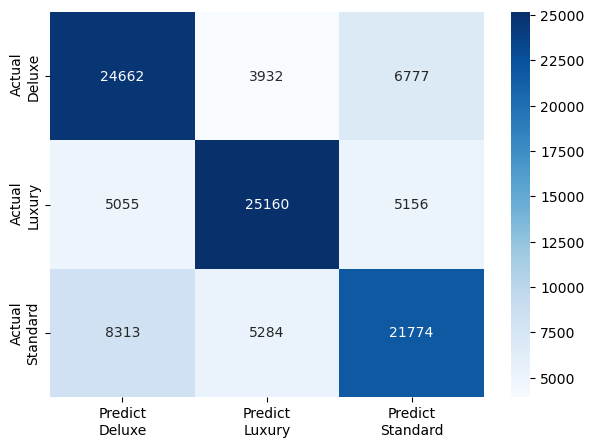

Test


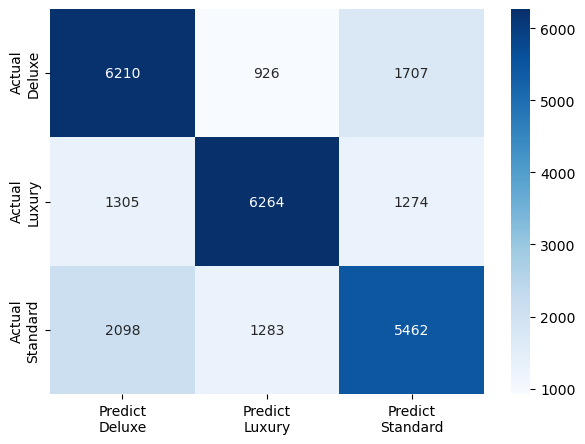


Performance Metrics
Train 
Test Accuracy: 0.6747
Test Precision: 0.6747
Test Recall: 0.6747
Test 
Test Accuracy: 0.6761
Test Precision: 0.6761
Test Recall: 0.6761


In [71]:
hyperparameter_dict = {
}
lr = Logistic_Regression(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, IS_NOTEBOOK)
lr.model_processing()

## Decision Tree Classifier

### RandomSearchCV

In [72]:
# hyperparameter_dict = {
# }
# dtc = Decision_Tree_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, 
#                                RANDOM_STATE, IS_NOTEBOOK)
# param_grid = {'max_depth':[9,10,12],
#               'criterion':['gini','entropy'],
#               'max_features': ['sqrt','log2'],
#               'min_samples_split':[2,4,6]
#              }
# dtc.RandomizedSearchCV(param_grid, 4)


### Model Train

Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     35371
           1       0.80      0.79      0.79     35371
           2       0.70      0.73      0.71     35371

    accuracy                           0.76    106113
   macro avg       0.76      0.76      0.76    106113
weighted avg       0.76      0.76      0.76    106113

Test 
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      8843
           1       0.77      0.76      0.77      8843
           2       0.66      0.69      0.68      8843

    accuracy                           0.73     26529
   macro avg       0.73      0.73      0.73     26529
weighted avg       0.73      0.73      0.73     26529


Confusion Metric
Train


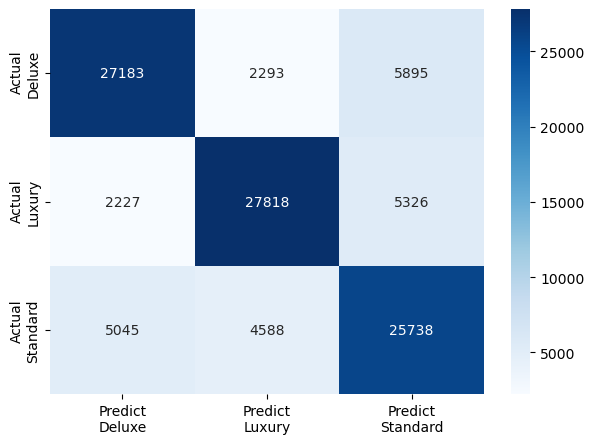

Test


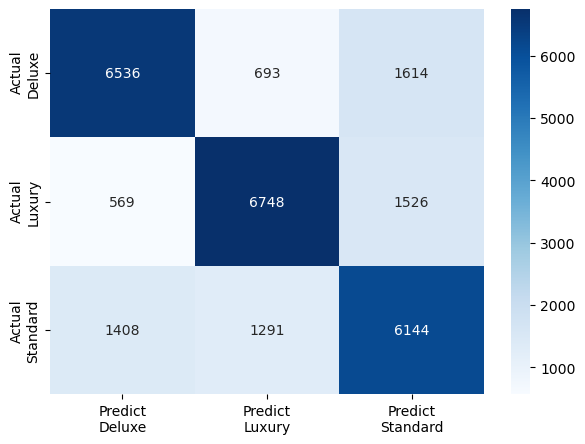


Performance Metrics
Train 
Test Accuracy: 0.7609
Test Precision: 0.7609
Test Recall: 0.7609
Test 
Test Accuracy: 0.7323
Test Precision: 0.7323
Test Recall: 0.7323


In [73]:
hyperparameter_dict = {
    'criterion':'gini', 
    'max_depth':12, 
    'min_samples_split':4, 
    'max_features':'sqrt'
}
DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=6)
dtc = Decision_Tree_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, IS_NOTEBOOK)
dtc_train = dtc.model_processing()
# X = dtc.return_X()
# dot_data = export_graphviz(dtc_train, out_file=None, feature_names=list(X.columns.values), 
#                         class_names=['Delxue', 'Luxury', 'Standard'], rounded=True, filled=True)
# from IPython.display import Image, display
# graph = pydotplus.graph_from_dot_data(dot_data)
# # Show graph
# Image(graph.create_png()) 

## Random Forest Classifier

### RandomSearchCV 

In [74]:
# hyperparameter_dict = {
# }
# rfc = Random_Forest_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, 
#                                IS_NOTEBOOK)
# # https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# param_grid = {
#       "n_estimators": [50, 100, 150, 200],
#         "criterion": ["gini", "entropy"],
#         "max_depth": [3, 5, 8],
#         "min_samples_split": [20, 24, 28],
#         "min_samples_leaf": [20, 24, 28],
#         "max_features": ["sqrt"],
#         "class_weight": ["balanced"]
#             }
# rfc.RandomizedSearchCV(param_grid, 1)

### Model Train

Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     35371
           1       0.84      0.79      0.82     35371
           2       0.75      0.71      0.73     35371

    accuracy                           0.78    106113
   macro avg       0.78      0.78      0.78    106113
weighted avg       0.78      0.78      0.78    106113

Test 
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      8843
           1       0.83      0.78      0.81      8843
           2       0.73      0.70      0.72      8843

    accuracy                           0.77     26529
   macro avg       0.77      0.77      0.77     26529
weighted avg       0.77      0.77      0.77     26529


Confusion Metric
Train


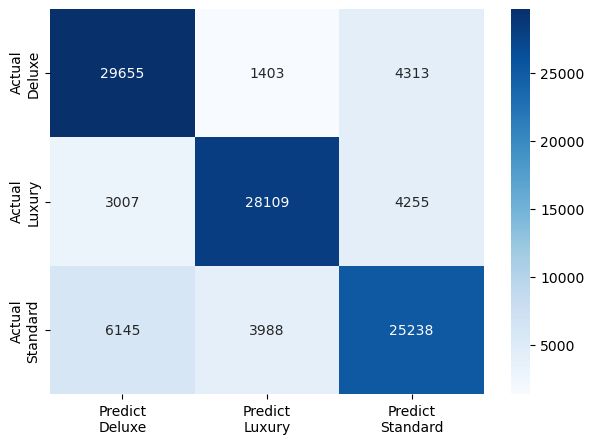

Test


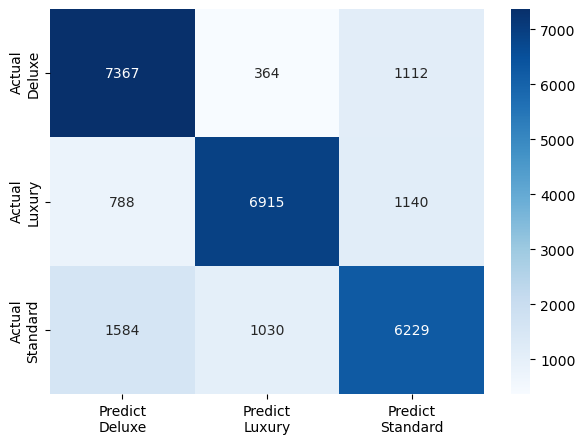


Performance Metrics
Train 
Test Accuracy: 0.7822
Test Precision: 0.7822
Test Recall: 0.7822
Test 
Test Accuracy: 0.7732
Test Precision: 0.7732
Test Recall: 0.7732


In [75]:
hyperparameter_dict = {
    'n_estimators':150, 
    'min_samples_split':20,
    'min_samples_leaf': 28,
    'max_features': 'sqrt',
    'max_depth': 8,
    'criterion': 'gini',
    'class_weight': 'balanced'
}

rfc = Random_Forest_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, 
                               IS_NOTEBOOK)
rfc.model_processing()

## Gradient Boosting Classifier

### RandomSearchCV

In [76]:
# hyperparameter_dict = {
# }
# gbc = Gradient_Boosting_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, 
#                                    IS_NOTEBOOK)
# param_grid = {
#     "n_estimators": [50, 100, 150, 200],
#     "criterion": ["friedman_mse", "squared_error"],
#     "min_samples_split": [20, 24, 28],
#     "min_samples_leaf": [20, 24, 28],
#     "max_depth": [3, 5, 8]
#     }
# gbc.RandomizedSearchCV(param_grid, 4)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END criterion=friedman_mse, max_depth=8, min_samples_leaf=20, min_samples_split=24, n_estimators=150;, score=0.599 total time=  52.4s
[CV 2/3] END criterion=friedman_mse, max_depth=8, min_samples_leaf=20, min_samples_split=24, n_estimators=150;, score=0.598 total time=  52.7s
[CV 3/3] END criterion=friedman_mse, max_depth=8, min_samples_leaf=20, min_samples_split=24, n_estimators=150;, score=0.603 total time=  52.1s
[CV 1/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_samples_split=28, n_estimators=100;, score=0.568 total time=  14.1s
[CV 2/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_samples_split=28, n_estimators=100;, score=0.567 total time=  14.0s
[CV 3/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_samples_split=28, n_estimators=100;, score=0.566 total time=  14.0s
[CV 1/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_sampl

[CV 1/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=100;, score=0.585 total time=  22.1s
[CV 2/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=100;, score=0.584 total time=  21.9s
[CV 3/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=100;, score=0.587 total time=  21.9s
[CV 1/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=150;, score=0.592 total time=  33.2s
[CV 2/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=150;, score=0.589 total time=  32.9s
[CV 3/3] END criterion=squared_error, max_depth=5, min_samples_leaf=20, min_samples_split=28, n_estimators=150;, score=0.590 total time=  32.7s
[CV 1/3] END criterion=friedman_mse, max_depth=5, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.593 total time= 

[CV 2/3] END criterion=squared_error, max_depth=8, min_samples_leaf=24, min_samples_split=24, n_estimators=200;, score=0.599 total time= 1.1min
[CV 3/3] END criterion=squared_error, max_depth=8, min_samples_leaf=24, min_samples_split=24, n_estimators=200;, score=0.602 total time= 1.2min
[CV 1/3] END criterion=squared_error, max_depth=5, min_samples_leaf=28, min_samples_split=24, n_estimators=50;, score=0.574 total time=  11.0s
[CV 2/3] END criterion=squared_error, max_depth=5, min_samples_leaf=28, min_samples_split=24, n_estimators=50;, score=0.573 total time=  10.9s
[CV 3/3] END criterion=squared_error, max_depth=5, min_samples_leaf=28, min_samples_split=24, n_estimators=50;, score=0.575 total time=  10.9s
[CV 1/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_samples_split=24, n_estimators=50;, score=0.558 total time=   6.9s
[CV 2/3] END criterion=friedman_mse, max_depth=3, min_samples_leaf=28, min_samples_split=24, n_estimators=50;, score=0.556 total time=   6.9s

### Model Train

In [ ]:
hyperparameter_dict = {
    'n_estimators': 200, 
    'min_samples_split': 28, 
    'min_samples_leaf': 24, 
    'max_depth': 8, 
    'criterion': 'friedman_mse'
}
gbc = Gradient_Boosting_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, IS_NOTEBOOK)
gbc.model_processing()

# Model Evaluation